## BART-BMM Examples

This notebook reproduces the BART-BMM examples shown in "Model Mixing Using Bayesian Additive Regression Trees." Each code cell can be executed by clicking the "play" button, which is found on the lefthand side of the cell. Alternatively, one can click inside the cell and use the command `shift + enter`.


### **Installation Step**

The first set of code cells will pull the openbt package from its github repository. It will then be installed in this ***virtual environment***.

In [ ]:
!wget -q https://github.com/jcyannotty/OpenBT/raw/main/openbt_mixing0.current_amd64-MPI_Ubuntu_20.04.deb

In [ ]:
!dpkg -i openbt_mixing0.current_amd64-MPI_Ubuntu_20.04.deb

Selecting previously unselected package openbt.
(Reading database ... 120500 files and directories currently installed.)
Preparing to unpack openbt_mixing0.current_amd64-MPI_Ubuntu_20.04.deb ...
Unpacking openbt (0.current-MPI) ...
Setting up openbt (0.current-MPI) ...


In [ ]:
!ldconfig

### **Python Setup**
Next, import the required python libraries.

In [ ]:
# Required Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm
from scipy.special import gamma
import sys
import os

The BART-BMM software is included in the Taweret python package. This package includes model mixing methodology developed by the Bayesian Analysis of Nuclear Dynamics (BAND) collaboration. It will be publicly released in the coming months.

In [ ]:
# Clone the Taweret Repo
!git clone https://github.com/jcyannotty/Taweret.git
!cd Taweret && git checkout develop

Cloning into 'Taweret'...
remote: Enumerating objects: 2200, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 2200 (delta 434), reused 445 (delta 393), pack-reused 1680
Receiving objects: 100% (2200/2200), 77.19 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (1176/1176), done.
Branch 'develop' set up to track remote branch 'develop' from 'origin'.
Switched to a new branch 'develop'


In [ ]:
sys.path.insert(0,'/content/Taweret')

Next, we can pull data required to reproduce these examples.

In [ ]:
!wget -q https://github.com/jcyannotty/OpenBT/raw/main/Python/eft_models.py

In [ ]:
!wget -q https://github.com/jcyannotty/OpenBT/raw/main/Examples/Data/honda_y_train.txt
!wget -q https://github.com/jcyannotty/OpenBT/raw/main/Examples/Data/2d_x_train.txt
!wget -q https://github.com/jcyannotty/OpenBT/raw/main/Examples/Data/2d_y_train.txt

### **Taweret and EFT Setup**

The following lines of code import specific modules from Taweret which are required to reproduce these examples. Additionally, the EFT model class is created (honda_models).

In [ ]:
# Taweret Imports
from Taweret.models.polynomial_models import sin_exp, cos_exp, sin_cos_exp
from Taweret.mix.trees import Trees
from Taweret.core.base_model import BaseModel

In [ ]:
import eft_models as eft

In [ ]:
# Wrap honda models
class honda_models(BaseModel):
  def __init__(self,sg = True, N = 2):
        self.N = N
        self.sg = sg

  def evaluate(self, x):
      if isinstance(x, list):
          x = np.array(x)
      if self.sg:
        m = eft.fsg(x,self.N)
        s = eft.dsg(x,self.N)
      else:
        m = eft.flg(x,self.N)
        s = eft.dlg(x,self.N)
      if len(m.shape) == 1:
        m = m.reshape(m.shape[0],1)
        s = s.reshape(s.shape[0],1)
      return m,s

  def set_prior(self):
      return super().set_prior()

  def log_likelihood_elementwise(self):
      return super().log_likelihood_elementwise()


### **Example 1a:**

This section provides the code to reproduce the BART-BMM results for the first EFT example in the manuscript.

The BART-BMM model is trained using the following steps.

1. Define the model set using the three lines of code shown below. The first two lines define a class instance for each EFT model. The third line of code defines the model set.  

In [ ]:
# Load the models, create the model set
fs2 = honda_models(True,2)
fl4 = honda_models(False,4)
model_dict = {"model1":fs2,"model2":fl4}

In [ ]:
# Format training and test data
x_train = np.linspace(0.03,0.5,num = 20)
x_test = np.linspace(0.03,0.5,num = 200)
y_train = np.loadtxt("honda_y_train.txt")

y_train = y_train.reshape(20,1)
x_train = x_train.reshape(20,1)
x_test = x_test.reshape(200,1)


2. Define the class instance of the BART-BMM model using the `Trees` class. For this example, the class instance is called `mix`.

3. Set the prior information using the `set_prior()` method.

4. Fit the model using the `train()`. This requires the user to pass in the data and relevant MCMC arguments.  

In [ ]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict, google_colab = True)

# Set prior information
mix.set_prior(k=5.5,ntree=10,overallnu=5,overallsd=0.01,inform_prior=True)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 20000, nadapt = 5000, nskip = 2000, adaptevery = 500, minnumbot = 3,
                tc = 2,numcut = 300)


Results stored in temporary path: /tmp/openbtpy_g53ic6t1
Running model...


5. Obtain the predictions from the mixed function and the corresponding weight functions using the methods `predict()` and `predict_weights()`, respectively. Both methods require an array of test points and a confidence level.

In [ ]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


6. Plot the resulting predictions and weight functions.

In [ ]:
# Predictions - Upper and Lower ci bounds
plower = pci[0]
pupper = pci[1]

# Weight Functions - Upper and Lower ci bounds
wlower = wci[0]
wupper = wci[1]

# EFT predictions at test points
f_test = [fs2.evaluate(x_test)[0],fl4.evaluate(x_test)[0]]

# Define the underlying true model
fdagger = eft.f_dagger(x_test)

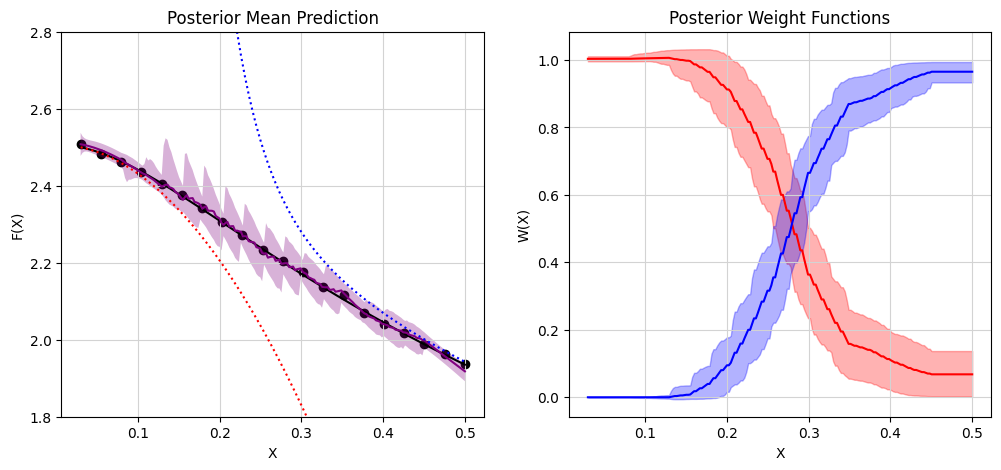

In [ ]:
# Plot the predictions and weight functions
col_list = ['red','blue','green','purple','orange']

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(x_test, fdagger, color = 'black')
ax[0].plot(x_test, pmean, color = 'purple')
for i in range(2):
    ax[0].plot(x_test, f_test[i], color = col_list[i], linestyle = 'dotted')
ax[0].scatter(x_train ,y_train,c="black")
ax[0].set_title("Posterior Mean Prediction")
ax[0].set_xlabel("X")
ax[0].set_ylabel("F(X)")
ax[0].set_ylim(1.8,2.8)
ax[0].fill_between(x_test.reshape(200,), plower, pupper, facecolor='purple', alpha=0.3)
ax[0].grid(True, color='lightgrey')


for i in range(2):
    ax[1].plot(x_test, wmean[:,i], color = col_list[i])
    ax[1].fill_between(x_test.reshape(200,), wlower[:,i], wupper[:,i], color = col_list[i], alpha = 0.3)
ax[1].set_title("Posterior Weight Functions")
ax[1].set_xlabel("X")
ax[1].set_ylabel("W(X)")
ax[1].grid(True, color='lightgrey')


plt.show()

### **Example 1b:**

This section provides the code to reproduce the BART-BMM results for example 1b in the manuscript.

The BART-BMM model is trained using the following steps.

1. Define the model set using the three lines of code shown below. The first two lines define a class instance for each EFT model. The third line of code defines the model set.  

In [ ]:
# Redefine the model set
fs4 = honda_models(True,4)
model_dict = {"model1":fs4,"model2":fl4}

2. Define the class instance of the BART-BMM model using the `Trees` class. For this example, the class instance is called `mix`.

3. Set the prior information using the `set_prior()` method.

4. Fit the model using the `train()`. This requires the user to pass in the data and relevant MCMC arguments.  

In [ ]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict, google_colab = True)

# Set prior information
mix.set_prior(k=5.0,ntree=10,overallnu=5,overallsd=0.01,inform_prior=True)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 20000, nadapt = 5000, nskip = 2000, adaptevery = 500, minnumbot = 3,
                tc = 2,numcut = 300)


Results stored in temporary path: /tmp/openbtpy_ya3zown0
Running model...


5. Obtain the predictions from the mixed function and the corresponding weight functions using the methods `predict()` and `predict_weights()`, respectively. Both methods require an array of test points and a confidence level.

In [ ]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


6. Plot the predictions and weight functions.

In [ ]:
# Predcition upper and lower bounds
plower = pci[0]
pupper = pci[1]

# Weight Functions upper and lower bounds
wlower = wci[0]
wupper = wci[1]

# F test data
f_test = [fs4.evaluate(x_test)[0],fl4.evaluate(x_test)[0]]

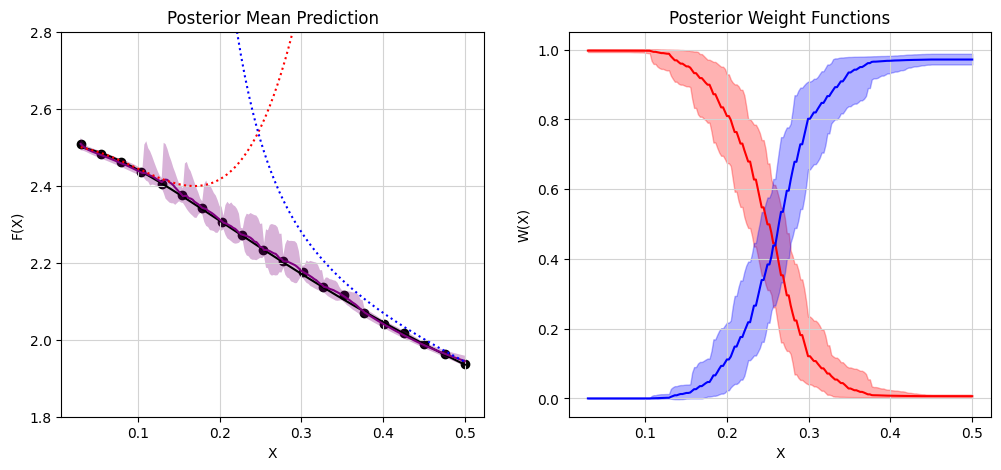

In [ ]:
# Plot the predictions and weight functions
col_list = ['red','blue','green','purple','orange']

fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(x_test, fdagger, color = 'black')
ax[0].plot(x_test, pmean, color = 'purple')
for i in range(2):
    ax[0].plot(x_test, f_test[i], color = col_list[i], linestyle = 'dotted')
ax[0].scatter(x_train ,y_train,c="black")
ax[0].set_title("Posterior Mean Prediction")
ax[0].set_xlabel("X") # Update Label
ax[0].set_ylabel("F(X)") # Update Label
ax[0].set_ylim(1.8,2.8)
ax[0].fill_between(x_test.reshape(200,), plower, pupper, facecolor='purple', alpha=0.3)
ax[0].grid(True, color='lightgrey')


for i in range(2):
    ax[1].plot(x_test, wmean[:,i], color = col_list[i])
    ax[1].fill_between(x_test.reshape(200,), wlower[:,i], wupper[:,i], color = col_list[i], alpha = 0.3)
ax[1].set_title("Posterior Weight Functions")
ax[1].set_xlabel("X")
ax[1].set_ylabel("W(X)")
ax[1].grid(True, color='lightgrey')

plt.show()

## **Example 2**

The BART-BMM model is trained using the following steps.

1. Define the model set using the three lines of code shown below. The first two lines define a class instance for each Taylor series expansion. The third line of code defines the model set.  

In [ ]:
# Define the model set
f1 = sin_cos_exp(7,10,np.pi,np.pi) # 7th order sin(x1) + 10th order cos(x2)
f2 = sin_cos_exp(13,6,-np.pi,-np.pi) # 13th order sin(x1) + 6th order cos(x2)
model_dict = {'model1':f1, 'model2':f2}

# Get train data
x_train = np.loadtxt("2d_x_train.txt").reshape(80,2)
x_train = x_train.reshape(2,80).transpose()

y_train = np.loadtxt("2d_y_train.txt").reshape(80,1)

# Get test data
n_test = 30
x1_test = np.outer(np.linspace(-np.pi, np.pi, n_test), np.ones(n_test))
x2_test = x1_test.copy().transpose()
f0_test = (np.sin(x1_test) + np.cos(x2_test))
x_test = np.array([x1_test.reshape(x1_test.size,),x2_test.reshape(x1_test.size,)]).transpose()


2. Define the class instance of the BART-BMM model using the `Trees` class. For this example, the class instance is called `mix`.

3. Set the prior information using the `set_prior()` method.

4. Fit the model using the `train()`. This requires the user to pass in the data and relevant MCMC arguments.  

In [ ]:
# Fit the BMM Model
# Initialize the Trees class instance
mix = Trees(model_dict = model_dict, google_colab = True)

# Set prior information
mix.set_prior(k=2.0,ntree=30,overallnu=5,overallsd=0.01,inform_prior=False)

# Train the model
fit = mix.train(X=x_train, y=y_train, ndpost = 5000, nadapt = 2000, nskip = 1000, adaptevery = 200, minnumbot = 4, tc = 2)


Results stored in temporary path: /tmp/openbtpy_k074kw9y
Running model...


5. Obtain the predictions from the mixed function and the corresponding weight functions using the methods `predict()` and `predict_weights()`, respectively. Both methods require an array of test points and a confidence level.

In [ ]:
# Get predictions
ppost, pmean, pci, pstd = mix.predict(X = x_test, ci = 0.95)
wpost, wmean, wci, wstd = mix.predict_weights(X = x_test, ci = 0.95)


Text(0.5, 0.98, 'Posterior Mean Residuals and Weight Functions')

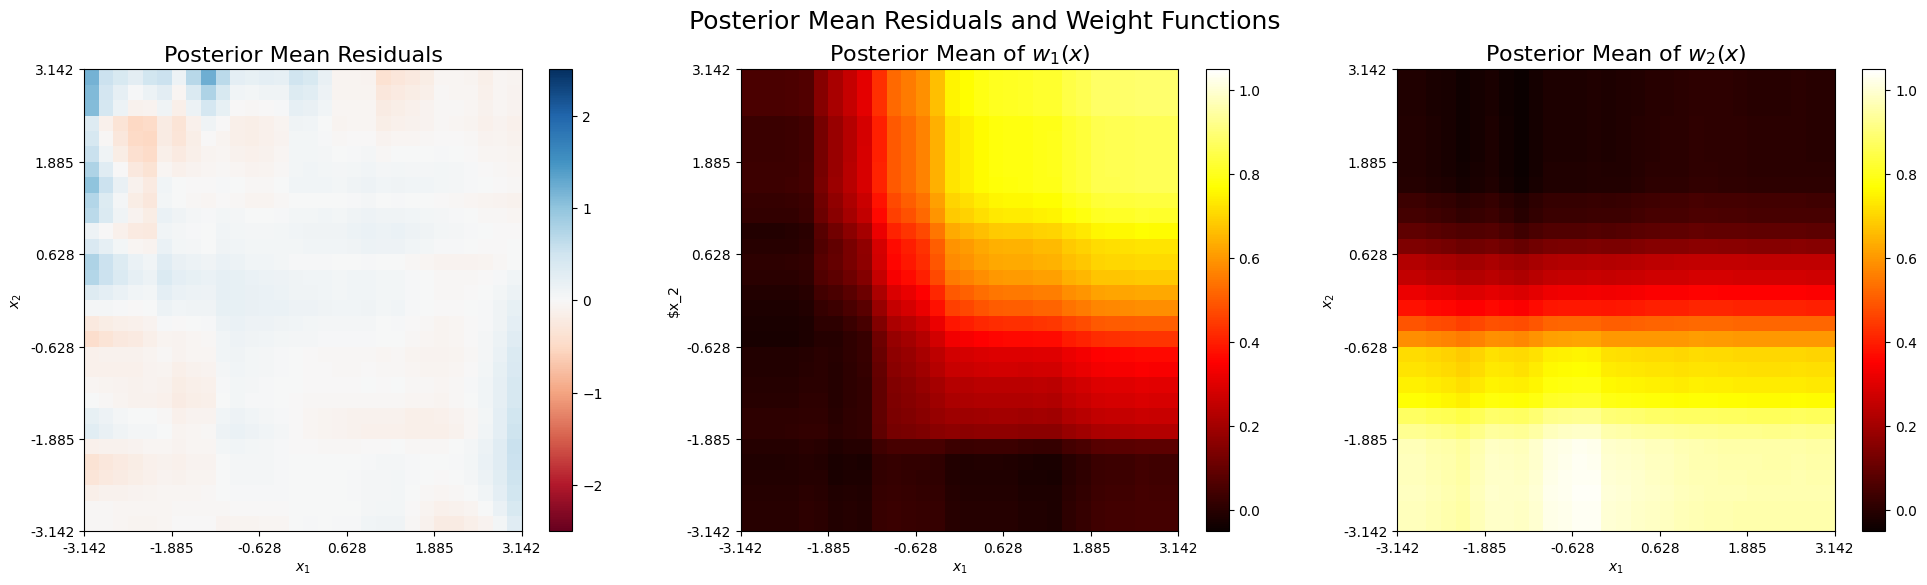

In [ ]:
# The posterior mean weight functions
cmap_hot = plt.get_cmap('hot')
w1 = wmean.transpose()[0]
w2 = wmean.transpose()[1]

w1_mean = wmean.transpose()[0]
w1_mean = w1_mean.reshape(x1_test.shape).transpose()

w2_mean = wmean.transpose()[1]
w2_mean = w2_mean.reshape(x1_test.shape).transpose()

w_sum = w1_mean + w2_mean

# Posterior Mean resiudals
cmap_rb = plt.get_cmap("RdBu")
fig, ax = plt.subplots(1,3, figsize = (24,6))

pcm1 = ax[0].pcolormesh((f0_test - pmean.reshape(x1_test.shape)).transpose(),cmap = cmap_rb, vmin = -2.5, vmax = 2.5)
ax[0].set_title("Posterior Mean Residuals", size = 16)
ax[0].set(xlabel = "$x_1$", ylabel = "$x_2$")
ax[0].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[0].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[0].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))

fig.colorbar(pcm1,ax = ax[0])

pcm0 = ax[1].pcolormesh(w1_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
ax[1].set_title("Posterior Mean of $w_1(x)$", size = 16)
ax[1].set(xlabel = "$x_1$", ylabel = "$x_2")
ax[1].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[1].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[1].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm0,ax = ax[1])

pcm2 = ax[2].pcolormesh(w2_mean,cmap = cmap_hot, vmin = -0.05, vmax = 1.05)
ax[2].set_title("Posterior Mean of $w_2(x)$", size = 16)
ax[2].set(xlabel = "$x_1$", ylabel = "$x_2$")
ax[2].xaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[2].xaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
ax[2].yaxis.set_major_locator(ticker.FixedLocator(np.round(np.linspace(0, n_test, 6),3)))
ax[2].yaxis.set_major_formatter(ticker.FixedFormatter(np.round(np.linspace(-np.pi, np.pi, 6),3)))
fig.colorbar(pcm2,ax = ax[2])
fig.suptitle("Posterior Mean Residuals and Weight Functions", size = 18)
